### Calculating and Plotting S(Q,w)

**Calculating Phonon Frequencies/Eigenvectors**

First read in the force constants

In [1]:
from euphonic import ForceConstants

fc = ForceConstants.from_castep('castep_files/quartz.castep_bin')

# You could try plotting S(Q,w) for graphite too
# fc = ForceConstants.from_castep('castep_files/graphite.castep_bin')

We can use `Numpy` to generate a slice of q-points

In [2]:
import numpy as np

n_qpts = 500
qpts = np.zeros((n_qpts, 3))
qh = np.linspace(0., 5., n_qpts)
qpts[:, 1] = qh

We can then use `calculate_qpoint_phonon_modes` to interpolate the
force constants to create a `QpointPhononModes` object containing
all the frequencies and eigenvectors at those q-points

In [3]:
phonons = fc.calculate_qpoint_phonon_modes(qpts)

**Calculating the Debye-Waller Exponent**

This is an optional part of the structure factor calculation.
We must first calculate phonon frequencies on a grid, then calculate
the Debye-Waller exponent with `calculate_debye_waller`. It must
be provided with the temperature as a `pint.Quantity`

In [4]:
from euphonic import ureg
from euphonic.util import mp_grid

qpts = mp_grid([6,6,6])
phonons_grid = fc.calculate_qpoint_phonon_modes(qpts)
temperature = 5*ureg('K')
dw = phonons_grid.calculate_debye_waller(temperature)

**Calculating the Structure Factor**

We can now calculate the structure factor for every q-point with
`calculate_structure_factor`.

The coherent neutron scattering lengths for each atom in the structure
must be provided as a dictionary, specifying the units as a `pint.Quantity`.

We can also include the Debye-Waller factor by passing in the Debye-Waller
exponent calculated previously

In [5]:
fm = ureg('fm')
scattering_lengths = {'Si': 4.1491*fm, 'O': 5.803*fm}
sf = phonons.calculate_structure_factor(scattering_lengths, dw=dw)

**Calculating the S(Q,w) Map**

From the structure factor, we can calculate the S(Q,w) map, we just
need to provide the energy bins in the correct units

In [6]:
energy_bins = np.arange(0, 160.5, 0.25)*ureg('meV')
sqw = sf.calculate_sqw_map(energy_bins)

**Plotting the S(Q,w) Map**

`sqw` is a `Spectrum2D` object, so can easily be plotted.

There are many options for plotting, try `help(plot_2d)`

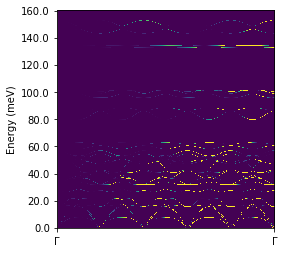

In [9]:
from euphonic.plot import plot_2d

fig, ims = plot_2d(sqw, ratio=1.0, vmax=1e-10,
                   y_label=f'Energy ({sqw.y_data.units:~P})')

By default there is no broadening applied. To make the
plot look more realistic, use the `Spectrum2D.broaden`
function, and plot again

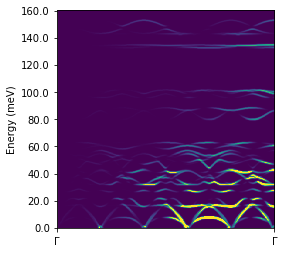

In [10]:
energy_width = 1.0*ureg('meV')
q_width = 0.05*ureg('1/angstrom')
sqw_broaden = sqw.broaden(y_width=energy_width, x_width=q_width)
fig, ims = plot_2d(sqw_broaden, ratio=1.0, vmax=1e-10,
                   y_label=f'Energy ({sqw.y_data.units:~P})')